# Modeling the expert: an introduction to logistic regression

We'll examine how analytics can model an expert, in this case a physician, in the context of assessing the quality of healthcare patients receive, and introduce a technique called logistic regression to achieve this objective.

The quality of healthcare is an important objective. If one identifies patients that have low quality care, one can intervene and improve outcomes for these patients. Moreover, assessing quality correctly can control costs better. However, defining quality is a complex, not well-defined task. Currently, assessing quality is done by physicians who are experts in the health space using their knowledge, their expertise, and their intuition. 
Clearly, physicians cannot assess quality for millions of patients. So the key question is as follows. 

Can we develop analytics tools that replicate expert assessment on a large scale?

The goal is to learn from expert human judgment by developing a model, interpret the results of the model, and further adjust the model to improve predictability. The objective is to make predictions and evaluations on a large scale basis, to be able to process millions of assessing the health care quality for millions of people. So the lecture is a story of using analytics in identifying poor quality care using claims data.

## About the data

The objective was to assess quality, health care quality. So we used a large health insurance claims database, and we randomly selected 131 diabetes patients.

* Large health insurance claims database.
* Randomly selected 131 diabetes patients.
* Ages: from 35 to 55
* Costs: \$10,000 - $20,000
* The period in which these claims were recorded: September 1, 2003 - August 31, 2005

An expert physician reviewed the claims and wrote descriptive notes and rated the quality of care on a **two-point scale**, **poor** or **good**.

## Loading the data

### Libraries

In [1]:
# Basic libraries
import pandas as pd
import numpy as np

In [5]:
quality = pd.read_csv('../../datasets/quality.csv')
quality.head()

,MemberID,InpatientDays,ERVisits,OfficeVisits,Narcotics,DaysSinceLastERVisit,Pain,TotalVisits,ProviderCount,MedicalClaims,ClaimLines,StartedOnCombination,AcuteDrugGapSmall,PoorCare
0,1,0,0,18,1,731.0,10,18,21,93,222,False,0,0
1,2,1,1,6,1,411.0,0,8,27,19,115,False,1,0
2,3,0,0,5,3,731.0,10,5,16,27,148,False,5,0
3,4,0,1,19,0,158.0,34,20,14,59,242,False,0,0
4,5,8,2,19,3,449.0,10,29,24,51,204,False,0,0


### Dataset info

In [6]:
quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 14 columns):
MemberID                131 non-null int64
InpatientDays           131 non-null int64
ERVisits                131 non-null int64
OfficeVisits            131 non-null int64
Narcotics               131 non-null int64
DaysSinceLastERVisit    131 non-null float64
Pain                    131 non-null int64
TotalVisits             131 non-null int64
ProviderCount           131 non-null int64
MedicalClaims           131 non-null int64
ClaimLines              131 non-null int64
StartedOnCombination    131 non-null bool
AcuteDrugGapSmall       131 non-null int64
PoorCare                131 non-null int64
dtypes: bool(1), float64(1), int64(12)
memory usage: 13.5 KB


The variables in the dataset `quality.csv` are as follows:

* **MemberID** numbers the patients from 1 to 131, and is just an identifying number.
* **InpatientDays** is the number of inpatient visits, or number of days the person spent in the hospital.
* **ERVisits** is the number of times the patient visited the emergency room.
* **OfficeVisits** is the number of times the patient visited any doctor’s office.
* **Narcotics** is the number of prescriptions the patient had for narcotics.
* **DaysSinceLastERVisit** is the number of days between the patient’s last emergency room visit and the end of the study period (set to the length of the study period if they never visited the ER).
* **Pain** is the number of visits for which the patient complained about pain.
* **TotalVisits** is the total number of times the patient visited any healthcare provider.
* **ProviderCount** is the number of providers that served the patient.
* **MedicalClaims** is the number of days on which the patient had a medical claim.
* **ClaimLines** is the total number of medical claims.
* **StartedOnCombination** is whether or not the patient was started on a combination of drugs to treat their diabetes (TRUE or FALSE).
* **AcuteDrugGapSmall** is the fraction of acute drugs that were refilled quickly after the prescription ran out.
* **PoorCare** is the outcome or dependent variable, and is equal to 1 if the patient had poor care, and equal to 0 if the patient had good care.

## Exploratory data analysis

In [7]:
# Basic libraries
import matplotlib.pyplot as plt
import seaborn as sns

# seaborn style
sns.set()

In [9]:
# Matriz de correlaciones
corr = quality.corr()
corr

,MemberID,InpatientDays,ERVisits,OfficeVisits,Narcotics,DaysSinceLastERVisit,Pain,TotalVisits,ProviderCount,MedicalClaims,ClaimLines,StartedOnCombination,AcuteDrugGapSmall,PoorCare
MemberID,1.000000,-0.063620,-0.011032,-0.006273,0.203962,0.100174,0.023700,-0.032954,0.012511,-0.065212,-0.090459,-0.144841,0.196651,0.060916
InpatientDays,-0.063620,1.000000,0.440087,0.175901,-0.093769,-0.290121,0.304058,0.622036,0.244023,0.286378,0.386951,0.105626,-0.001144,0.080726
ERVisits,-0.011032,0.440087,1.000000,0.308526,-0.003732,-0.735246,0.546779,0.586439,0.457429,0.355319,0.542001,0.118766,-0.072750,0.135401
OfficeVisits,-0.006273,0.175901,0.308526,1.000000,0.275759,-0.128388,0.352968,0.865387,0.365469,0.498513,0.424953,0.164056,0.200735,0.329512
Narcotics,0.203962,-0.093769,-0.003732,0.275759,1.000000,0.065055,0.106860,0.163992,0.293478,0.220541,0.185799,0.043641,0.710889,0.447236
DaysSinceLastERVisit,0.100174,-0.290121,-0.735246,-0.128388,0.065055,1.000000,-0.358781,-0.344640,-0.297701,-0.198114,-0.412797,-0.061953,0.131085,-0.107983
Pain,0.023700,0.304058,0.546779,0.352968,0.106860,-0.358781,1.000000,0.482959,0.405095,0.296697,0.464713,0.078373,-0.031490,0.092168
TotalVisits,-0.032954,0.622036,0.586439,0.865387,0.163992,-0.344640,0.482959,1.000000,0.451545,0.549308,0.569619,0.185814,0.134861,0.300540
ProviderCount,0.012511,0.244023,0.457429,0.365469,0.293478,-0.297701,0.405095,0.451545,1.000000,0.517002,0.605357,0.155765,0.141284,0.220166
MedicalClaims,-0.065212,0.286378,0.355319,0.498513,0.220541,-0.198114,0.296697,0.549308,0.517002,1.000000,0.813935,0.067931,0.085637,0.167399


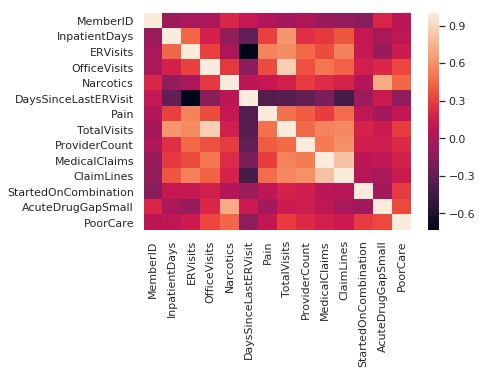

In [10]:
# heatmap
sns.heatmap(corr)
plt.show()

In [23]:
variables = corr.loc['PoorCare', np.abs(corr.loc['PoorCare']) > 0.2]
variables = variables.index.values
print(variables)

['OfficeVisits' 'Narcotics' 'TotalVisits' 'ProviderCount'
 'StartedOnCombination' 'AcuteDrugGapSmall' 'PoorCare']


### Variable Extraction

* Dependent Variable:
    * Quality of care, a categorical variable.
    

* Independent Variables:
    * OfficeVisits
    * Narcotics
    * TotalVisits
    * ProviderCount
    * StartedOnCombination
    * AcuteDrugGapSmall
    * PoorCare  

In [26]:
quality_model1 = quality[variables]
quality_model1.head()

,OfficeVisits,Narcotics,TotalVisits,ProviderCount,StartedOnCombination,AcuteDrugGapSmall,PoorCare
0,18,1,18,21,False,0,0
1,6,1,8,27,False,1,0
2,5,3,5,16,False,5,0
3,19,0,20,14,False,0,0
4,19,3,29,24,False,0,0


### Exploratory data analysis

/home/pablo/Programas/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/pablo/Programas/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


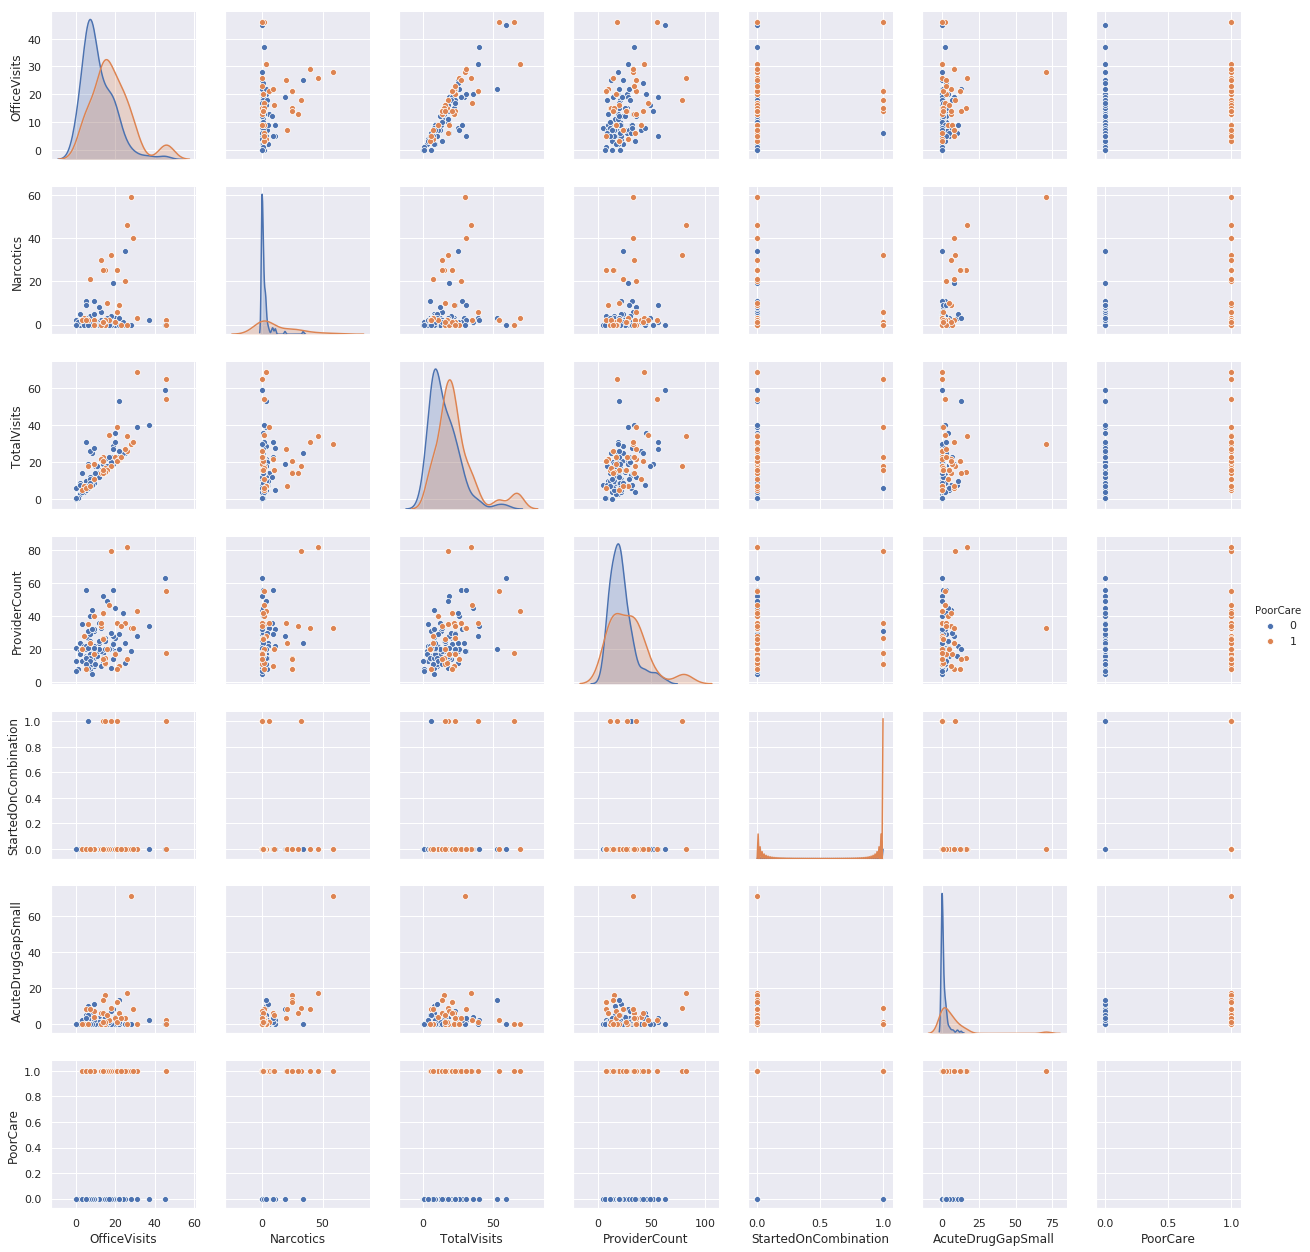

In [28]:
sns.pairplot(quality_model1, hue='PoorCare')
plt.show()

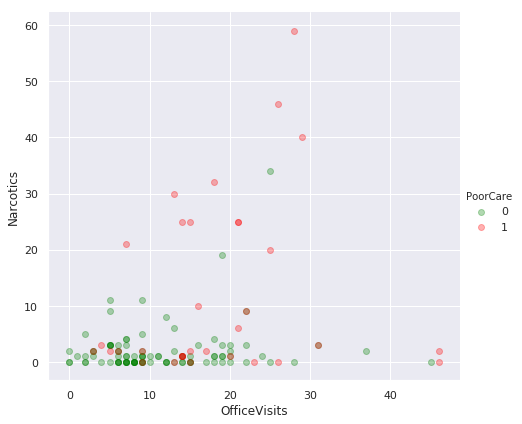

In [52]:
sns.lmplot(x='OfficeVisits', y='Narcotics', data=quality,
           hue='PoorCare', fit_reg=False, logistic=False,
           palette=['green', 'red'], scatter_kws={'alpha':0.3},
          aspect = 1.1, height= 6)
plt.show()

This plot shows two of our independent variables,

* the number of office visits on the x-axis (`OfficeVisits`), and
* the number of narcotics prescribed on the y-axis (`Narcotics`).

Each point is an observation or a patient in our data set.
The red points are patients who received poor care, and the green points are patients who received good care. It looks like maybe more office visits and more narcotics are more likely to correspind to poor care.

### Univariate analysis

In [57]:
narcotics = quality['Narcotics'].values
poorcare = quality['PoorCare'].values

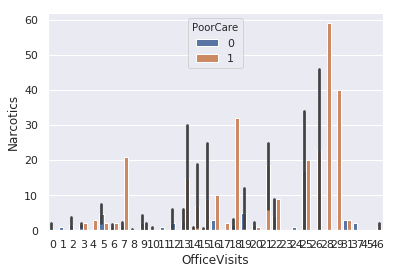

In [68]:
# number of bins

# visualizations
sns.barplot('OfficeVisits','Narcotics', hue='PoorCare', data=quality)
plt.show()